# Health insurance cross sell prediction with XGBoost

## 1. Problem description

[Kaggle source](https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction)
This dataset contains a list of health insurance customers. The "Response" column indicates whether the customer also wanted to use car insurance. I'll try to build a model that predicts this decision.

In [1]:
from common import *

print("Number of rows:", df.shape[0])
df.head()

Number of rows: 381109


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 2. Initial data visualization
TODO

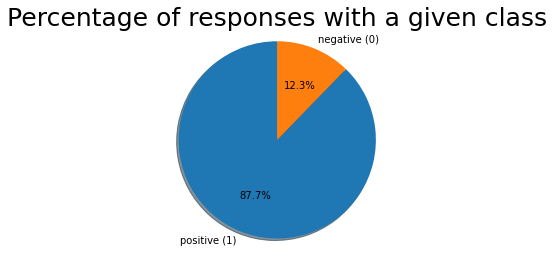

In [2]:
labels = ["positive (1)", "negative (0)"]
negative = df[df.Response == 0].size
positive = df[df.Response == 1].size
sizes = [negative, positive]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Percentage of responses with a given class", fontsize=25)
plt.show()

There are much more (87,7%) people witch choose both insurances.

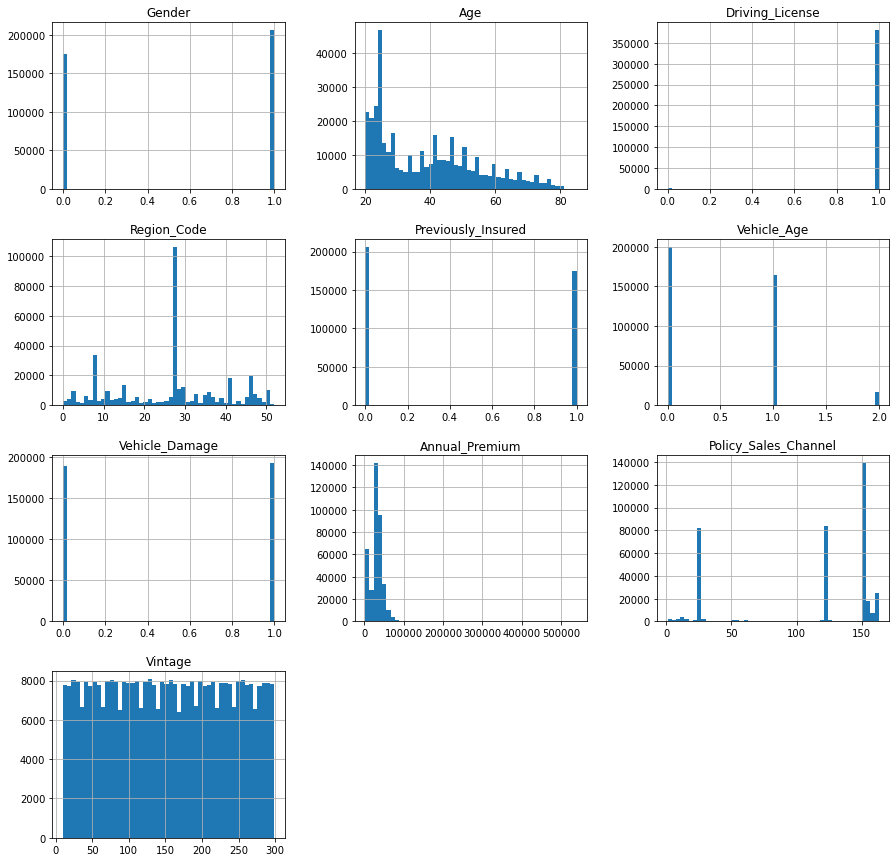

In [3]:
X_le.hist(bins=50, figsize=(15, 15))
plt.show()

TODO: conclusions from histogram

## 3. Basic model with logistic regression
TODO

### 3.1 Metric
TODO: info about ROC_AUC and imbalanced dataset. Deep dive into ROC!

### 3.2 Cross validation

In [4]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42, n_jobs=-1)
score = cross_val_score(logreg, X_le, y, cv=10, scoring='roc_auc').mean()
print("Mean ROC_AUC score: ", str(score))

Mean ROC_AUC score:  0.6626219144051005


## 4. Simple model with XGBoost
TODO

In [5]:
xgb = XGBClassifier(n_jobs=-1, random_state=42, n_estimators=100, use_label_encoder=False, eval_metric="logloss")
score = cross_val_score(xgb, X_le, y, cv=10, scoring='roc_auc').mean()
print("Mean ROC_AUC score: ", str(score))

Mean ROC_AUC score:  0.8566651987755973


## 5 Remove 'Vintage' column

TODO: add description

In [6]:
score = cross_val_score(xgb, X_le.drop(columns="Vintage"), y, cv=10, scoring='roc_auc').mean()
print("Mean ROC_AUC score without 'Vintage' column: ", str(score))

Mean ROC_AUC score without 'Vintage' column:  0.8569795768105639


## 6. StandardScaler vs PowerTransformer vs QuantileTransformer

TODO: add description

In [11]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer

# TODO: determine which model returns log about scaling/more iterations
def compare_preprocessing(model, X, y):
    scaler = StandardScaler()
    transformer = PowerTransformer()
    scaler_without_std = StandardScaler(with_std=False)
    quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
    quant_trans_normal = QuantileTransformer(output_distribution='normal')

    model_scaler = make_pipeline(scaler, model)
    model_transformer = make_pipeline(transformer, model)
    model_scaler_transformer = make_pipeline(scaler_without_std, transformer, model)
    model_quant_trans_uniform = make_pipeline(quant_trans_uniform, model)
    model_quant_trans_normal = make_pipeline(quant_trans_normal, model)

    score_scaler = cross_val_score(model_scaler, X, y, cv=10, scoring='roc_auc').mean()
    score_transformer = cross_val_score(model_transformer, X, y, cv=10, scoring='roc_auc').mean()
    score_scaler_transformer = cross_val_score(model_scaler_transformer, X, y, cv=10, scoring='roc_auc').mean()
    score_quant_trans_uniform = cross_val_score(model_quant_trans_uniform, X, y, cv=10, scoring='roc_auc').mean()
    score_quant_trans_normal = cross_val_score(model_quant_trans_normal, X, y, cv=10, scoring='roc_auc').mean()

    print("Mean ROC_AUC score with scaler: ", str(score_scaler))
    print("Mean ROC_AUC score with transformer: ", str(score_transformer))
    print("Mean ROC_AUC score with scaler and transformer: ", str(score_scaler_transformer))
    print("Mean ROC_AUC score with QuantileTransformer (uniform distribution): ", str(score_quant_trans_uniform))
    print("Mean ROC_AUC score with QuantileTransformer (normal distribution): ", str(score_quant_trans_normal))

compare_preprocessing(xgb, X_le.drop(columns="Vintage"), y)
# xgb_scaler = make_pipeline(StandardScaler(), XGBClassifier(n_jobs=-1, random_state=42, n_estimators=100, use_label_encoder=False, eval_metric="logloss"))
# xgb_transformer = make_pipeline(PowerTransformer(), XGBClassifier(n_jobs=-1, random_state=42, n_estimators=100, use_label_encoder=False, eval_metric="logloss"))

# score_scaler = cross_val_score(xgb_scaler, X_le.drop(columns="Vintage"), y, cv=10, scoring='roc_auc').mean()
# score_transformer = cross_val_score(xgb_transformer, X_le.drop(columns="Vintage"), y, cv=10, scoring='roc_auc').mean()

# xgb_scaler_transformer = make_pipeline(StandardScaler(with_std=False), PowerTransformer(), XGBClassifier(n_jobs=-1, random_state=42, n_estimators=100, use_label_encoder=False, eval_metric="logloss"))
# score_scaler_transformer = cross_val_score(xgb_scaler_transformer, X_le.drop(columns="Vintage"), y, cv=10, scoring='roc_auc').mean()

# xgb_quant_trans_uniform = make_pipeline(QuantileTransformer(output_distribution='uniform'), XGBClassifier(n_jobs=-1, random_state=42, n_estimators=100, use_label_encoder=False, eval_metric="logloss"))
# score_xgb_quant_trans_uniform = cross_val_score(xgb_quant_trans_uniform, X_le.drop(columns="Vintage"), y, cv=10, scoring='roc_auc').mean()

# xgb_quant_trans_normal = make_pipeline(QuantileTransformer(output_distribution='normal'), XGBClassifier(n_jobs=-1, random_state=42, n_estimators=100, use_label_encoder=False, eval_metric="logloss"))
# score_xgb_quant_trans_normal = cross_val_score(xgb_quant_trans_normal, X_le.drop(columns="Vintage"), y, cv=10, scoring='roc_auc').mean()

# print("Mean ROC_AUC score with scaler: ", str(score_scaler))
# print("Mean ROC_AUC score with transformer: ", str(score_transformer))
# print("Mean ROC_AUC score with scaler and transformer: ", str(score_scaler_transformer))
# print("Mean ROC_AUC score with QuantileTransformer (uniform distribution): ", str(score_xgb_quant_trans_uniform))
# print("Mean ROC_AUC score with QuantileTransformer (normal distribution): ", str(score_xgb_quant_trans_normal))



/home/jsowa/anaconda3/envs/health_xgb_gpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jsowa/anaconda3/envs/health_xgb_gpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Mean ROC_AUC score with scaler:  0.8569739570255438
Mean ROC_AUC score with transformer:  0.8569796914052137
Mean ROC_AUC score with scaler and transformer:  0.8569772403805894
Mean ROC_AUC score with QuantileTransformer (uniform distribution):  0.857073061382106
Mean ROC_AUC score with QuantileTransformer (normal distribution):  0.8569845482310677


## 7. Vehicle age